## Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import time
import datetime

%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns

## Reading the datasets into pandas dataframes

In [3]:
events_df = pd.read_csv('Ecommerce_dataset/events.csv')
category_tree_df = pd.read_csv('Ecommerce_dataset/category_tree.csv')
item_properties_1_df = pd.read_csv('Ecommerce_dataset/item_properties_part1.csv')
item_properties_2_df = pd.read_csv('Ecommerce_dataset/item_properties_part2.csv')
items_df = pd.concat([item_properties_1_df,item_properties_2_df])

## A look at the data

In [4]:
times=[]
for i in events_df['timestamp']:
    times.append(datetime.datetime.fromtimestamp(i//1000.0))
events_df['timestamp'] = times
events_df.head()

,timestamp,visitorid,event,itemid,transactionid
0,2015-06-02 10:32:12,257597,view,355908,NaN
1,2015-06-02 11:20:14,992329,view,248676,NaN
2,2015-06-02 10:43:19,111016,view,318965,NaN
3,2015-06-02 10:42:35,483717,view,253185,NaN
4,2015-06-02 10:32:17,951259,view,367447,NaN


In [5]:
category_tree_df.head()

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


In [6]:
times=[]
for i in items_df['timestamp']:
    times.append(datetime.datetime.fromtimestamp(i//1000.0))
items_df['timestamp'] = times
items_df.head()

,timestamp,itemid,property,value
0,2015-06-28 08:30:00,460429,categoryid,1338
1,2015-09-06 08:30:00,206783,888,1116713 960601 n277.200
2,2015-08-09 08:30:00,395014,400,n552.000 639502 n720.000 424566
3,2015-05-10 08:30:00,59481,790,n15360.000
4,2015-05-17 08:30:00,156781,917,828513


## Comparison of frequency of 'View', 'Add to Cart', 'Transaction'

addtocart      69332
transaction    22457
Name: event, dtype: int64


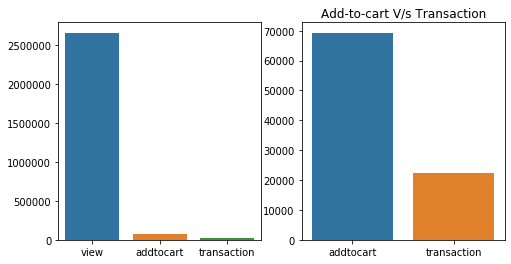

In [7]:
events_count = events_df["event"].value_counts()
fig, axs = plt.subplots(ncols = 2,figsize = (8, 4))
#plt.title('Views/Add to Cart/Transactions')
sns.barplot(events_count.index, events_count.values, ax = axs[0])

events_count=events_df["event"].value_counts()[1:]
#plt.title('Actions Vs Count')
g = sns.barplot(events_count.index, events_count.values, ax = axs[1])
#g.set_yscale('log')
events_count = events_df["event"].value_counts()[1:]
plt.title('Add-to-cart V/s Transaction')
sns.barplot(events_count.index, events_count.values)

print(events_count)

In [8]:
# All unique visitor ids
all_customers = events_df.visitorid.unique()
# Total visits
total_visits = events_df.visitorid.size
print("Total number of visits: ",total_visits)
print("Number of unique customers: ",all_customers.size)

Total number of visits:  2756101
Number of unique customers:  1407580


In [9]:
# All unique items
all_items = items_df.itemid.unique()
print("Total unique items: ",all_items.size)

Total unique items:  417053


## Function to return user's history

In [10]:
def user_history(visitor_id):
    user_history = events_df[events_df.visitorid == visitor_id].sort_values('timestamp')
    return user_history

## User history of two visitors

In [11]:
user_history(102013)

,timestamp,visitorid,event,itemid,transactionid
1281305,2015-09-08 08:27:05,102013,view,332816,NaN


In [12]:
user_history(102019)

,timestamp,visitorid,event,itemid,transactionid
19690,2015-06-01 21:51:54,102019,view,49521,NaN
19501,2015-06-01 21:53:21,102019,addtocart,49521,NaN
14842,2015-06-01 21:53:32,102019,view,150318,NaN
19573,2015-06-01 21:54:31,102019,view,49521,NaN
8701,2015-06-01 21:54:54,102019,view,49521,NaN
19708,2015-06-01 21:55:45,102019,view,150318,NaN
8740,2015-06-01 21:57:22,102019,view,49521,NaN
814,2015-06-01 22:08:56,102019,transaction,150318,13556.0
19724,2015-06-01 22:08:56,102019,transaction,49521,13556.0


## Analyzing purchases

In [13]:
# All the customers who made a purchase
customer_purchased = events_df[events_df.transactionid.notnull()].visitorid.unique()
customer_purchased.size

11719

### Creating a list of purchased items

In [14]:
purchased_items = []
    
# Create another list that contains all their purchases 
for customer in customer_purchased:

    #Generate a Pandas series type object containing all the visitor's purchases and put them in the list
    purchased_items.append(list(events_df.loc[(events_df.visitorid == customer) & (events_df.transactionid.notnull())].itemid.values))

## Function to recommend items frequently bought together

In [15]:
# Function that would show items that were bought together
def recommend_bought_together(item_id, purchased_items):
    
    # More efficient implementation required
    recommender_list = []
    for x in purchased_items:
        if item_id in x:
            recommender_list += x
    
    # Merge recommender list and remove the item id
    recommender_list = list(set(recommender_list) - set([item_id]))
    
    return recommender_list

In [16]:
recommend_bought_together(49521,purchased_items)

[150318]

In [17]:
recommend_bought_together(302422, purchased_items)

[105792, 200793, 12836, 80582, 380775, 15335, 400969, 25353, 237753, 317178]

## Statistics of items
### Outputs: Most viewed items, Most added items, Most purchased items
### Potential use in inventory management, demand forecasting

In [18]:
# Grouping itemid by its event type and creating list of each of them
grouped = events_df.groupby('event')['itemid'].apply(list)
grouped

event
addtocart      [5206, 10572, 255275, 356475, 312728, 63312, 1...
transaction    [356475, 15335, 81345, 150318, 310791, 54058, ...
view           [355908, 248676, 318965, 253185, 367447, 22556...
Name: itemid, dtype: object

In [19]:
# Function to find most viewed, added to cart and purchased items
import operator
def product_stats(grouped=grouped, event='view'):
    events = grouped[event]
    # creating dictionary for key value pair 
    count_event ={}
    events = np.array(events[:])
    unique, counts = np.unique(events, return_counts=True)
    # converting unique and counts as a dictionay with key as unique and value as counts
    count_event = dict(zip(unique, counts))
    #sorting the dictionary
    sort_count_event = sorted(count_event.items(), key = operator.itemgetter(1), reverse = True)
    # keeping number of unique views on X-axis
    x = [i[0] for i in sort_count_event[:7]]
    # keeping count number of views on Y-axis
    y = [i[1] for i in sort_count_event[:7]]
    # Print top 5 most-viewed items
    print("Top 5 products in " + str(event) + " category: ",x[:5])
    sns.barplot(x, y, order=x, palette="rocket")

Top 5 products in view category:  [187946, 461686, 5411, 370653, 219512]


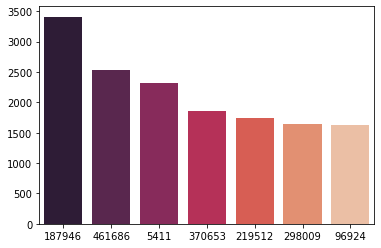

In [22]:
# Call function to see product stats
# events = 'view', 'addtocart', 'transaction'
product_stats(event='view')

Top 5 products in addtocart category:  [461686, 312728, 409804, 320130, 29196]


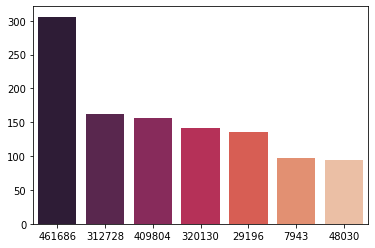

In [21]:
product_stats(event='addtocart')

Top 5 products in transaction category:  [461686, 119736, 213834, 7943, 312728]


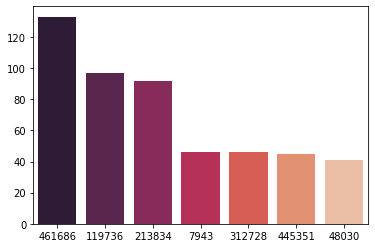

In [23]:
product_stats(event='transaction')